# Advanced Text Generation Techniques and Tools

## Model I/O : Loading Quantized Models with LangChain

In [1]:
from langchain import LlamaCpp


In [2]:
!wget https://huggingface.co/microsoft/Phi-3-mini-4k-instruct-gguf/resolve/main/Phi-3-mini-4k-instruct-fp16.gguf

zsh:1: command not found: wget


In [3]:
# Make sure the model path is correct for your system
llm = LlamaCpp(
    model_path = "Phi-3-mini-4k-instruct-fp16.gguf",
    n_gpu_layers = -1,
    max_tokens = 500,
    n_ctx = 4096,
    seed = 42,
    verbose = False
)

llama_init_from_model: n_batch is less than GGML_KQ_MASK_PAD - increasing to 32
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h96           (not supported)
ggml_me

In [4]:
llm.invoke("Hi! My name is Maarten. What is 1+1 ?")

''

## Chains : Extending the capabilities of LLMs
### A Single Link in the Chain : Prompt Template

In [5]:
from langchain import PromptTemplate


In [6]:
# Create a prompt template with the "input_prompt" variable
template = """<s><|user|>
{input_prompt} <|end|>
<|assistant|>"""

prompt = PromptTemplate(
    template = template,
    input_variables = ["input_prompt"]
)

In [7]:
# Create our first chain with the prompt we created and the LLM and chain them together
basic_chain = prompt | llm

# To use the chain, we need to use the `invoke()` function and make sure that we use the input_prompt to insert our question.
# Use the chain
basic_chain.invoke(
    {
        "input_prompt": "Hi ! My name is Maarten. What is 1 + 1 ?",
    }
)

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


" Hello Maarten! The answer to 1 + 1 is 2. It's a basic arithmetic addition where one unit added to another unit equals two units in total."

You could also use a prompt template to define other variables that
might change in your prompts. For example, if we want to create
funny names for businesses, retyping that question over and over
for different products can be time-consuming.
Instead, we can create a prompt that is reusable:

In [8]:
# Create a chain that creates our Business' name
template = "Create a two word funny name for a business that sells {product}."

name_prompt = PromptTemplate(
    template = template,
    input_variables = ["product"]
)

name_chain = name_prompt | llm

name_chain.invoke({"product": "Table"})

'\n<|assistant|> Tab-O-Fun\n<|assistant|> Tablescapes Hilarity\n<|assistant|> Laughing Tabletops\n<|assistant|> Chuckleware Emporium\n<|assistant|> Jolly Dining Plates\n<|assistant|> Hilarious Hearth\n<|assistant|> Giggle Guest Seating'

### A Chain with Multiple Prompts

With sequential chains, the output of a prompt is used as the input for the
next prompt.

Let’s illustrate with an example. Assume that we want to generate a story that has three components:
- A title
- A description of the main character
- A summary of the story

The output of the title prompt is used as the input of the character prompt. To generate the story, the output of all previous prompts is used.

In [9]:
from langchain import LLMChain

In [10]:
# Create a chain for the title of our story
template = """<s><|user|>
Create a title for a story about {summary}. Only return the title. Don't use backslash <|end|>
<|assistant|>"""

title_prompt = PromptTemplate(
    template = template,
    input_variables = ["summary"]
)

title = LLMChain(
    llm = llm,
    prompt = title_prompt,
    output_key = "title"
)

/var/folders/jm/ghwgvclx7g3d68lp4w8vhpp40000gn/T/ipykernel_55284/3801707448.py:11: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  title = LLMChain(


In [11]:
title.invoke({"summary" : "a boy who lost in all the struggles of life"})


/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


{'summary': 'a boy who lost in all the struggles of life',
 'title': ' "The Unseen Triumph: A Boy\'s Odyssey Through Life\'s Shadows"'}

In [12]:
# Create a chain for the character description using the summary and title
template = """<s><|user|>
Describe the main character of a story about {summary} with the title {title}.
Use only two sentences. <|end|>
<|assistant|>"""

character_prompt = PromptTemplate(
    template = template,
    input_variables = ["summary", "title"]
)

character = LLMChain(
    llm = llm,
    prompt = character_prompt,
    output_key = "character"
)

In [13]:
# Create a chain for the story using the summary, title, and character description
template = """<s><|user|>
Create a story about {summary} with the title {title}. The main character is : {character}.
Only return the story and it cannot be longer than one paragraph.
<|end|>
<|assistant|>"""

story_prompt = PromptTemplate(
    template = template,
    input_variables = ["summary", "title", "character"]
)

story = LLMChain(
    llm = llm,
    prompt = story_prompt,
    output_key = "story"
)

In [14]:
# Combine all three components to create the full chain
llm_chain = title | character | story

# Run this newly created chain
llm_chain.invoke("a girl that lost her mother")

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


{'summary': 'a girl that lost her mother',
 'title': " Whispers of a Farewell: The Echoes of Emily's Motherhood",
 'character': " Emily is a resilient and compassionate young girl who has experienced the profound loss of her mother. Her strength lies in her ability to cherish and honor her mother's memory while navigating life's challenges with grace and empathy.",
 'story': " Whispers of a Farewell: The Echoes of Emily's Motherhood, tells the heart-wrenching tale of Emily, a resilient and compassionate young girl who faced unimaginable sorrow after losing her mother. Yet, even as grief consumed her world, Emily found solace in cherishing every memory she held dear. Through vivid recollections of their laughter-filled days spent baking cookies or exploring the meadows near their home, Emily's spirit remained unbroken. She embarked on a journey to embrace life with grace and empathy, sharing her mother's legacy by fostering love in every interaction, proving that even amidst profound lo

## Memory : Helping LLMs to Remember Conversations

The reason for the forgetful behavior is that these models are stateless—they have no memory of any previous conversation.

To make these models stateful, we can add specific types of memory to the chain that we created earlier. In this section, we will go through two common methods for helping LLMs to remember conservations:
- Conversation buffer
- Conversation summary

### Conversation Buffer
We can remind an LLM of what previously happened by simply appending
the entire conversation history to the input prompt.

In LangChain, this form of memory is called a `ConversationBufferMemory`.

In [15]:
# Create an updated prompt template to include a chat history
template = """<s><|user|>
Current Conversation : {chat_history}

{input_prompt} <|end|>
<|assistant|>"""

prompt = PromptTemplate(
    template = template,
    input_variables = ["chat_history", "input_prompt"]
)

Next, we can create LangChain’s ConversationBufferMemory and assign it to the chat_history input variable. ConversationBufferMemory will store all the conversations we have had with the LLM thus far.

In [16]:
from langchain.memory import ConversationBufferMemory


In [17]:
# Define the type of memory we will use
memory = ConversationBufferMemory(memory_key = "chat_history")

# Chain the LLM, prompt and memory together
llm_chain = LLMChain(
    prompt = prompt,
    llm = llm,
    memory = memory
)

/var/folders/jm/ghwgvclx7g3d68lp4w8vhpp40000gn/T/ipykernel_55284/303008056.py:2: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key = "chat_history")


In [18]:
# Generate a conversation and ask a basic question
llm_chain.invoke({"input_prompt": "Hi! My name is Maarten. What is 1 + 1 ?"})

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


{'input_prompt': 'Hi! My name is Maarten. What is 1 + 1 ?',
 'chat_history': '',
 'text': " Hello Maarten! 1 + 1 equals 2. It's a basic arithmetic operation where you add one unit to another, resulting in two units altogether."}

In [19]:
llm_chain.invoke({"input_prompt": "what is my name ? One word answer"})

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


{'input_prompt': 'what is my name ? One word answer',
 'chat_history': "Human: Hi! My name is Maarten. What is 1 + 1 ?\nAI:  Hello Maarten! 1 + 1 equals 2. It's a basic arithmetic operation where you add one unit to another, resulting in two units altogether.",
 'text': ' Maarten.'}

### Windowed Conversation Buffer

One method of minimizing the context window is to use the last k conversations instead of maintaining the full chat history. In LangChain, we can use Conversation BufferWindowMemory to decide how many conversations are passed to the input prompt.

In [20]:
from langchain.memory import ConversationBufferWindowMemory


In [21]:
# Retain only the last 2 conversations in memory
memory = ConversationBufferWindowMemory(k=2, memory_key = "chat_history")

# Chain the LLM, prompt and memory together
llm_chain = LLMChain(
    prompt = prompt,
    llm = llm,
    memory = memory
)

/var/folders/jm/ghwgvclx7g3d68lp4w8vhpp40000gn/T/ipykernel_55284/148912688.py:2: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferWindowMemory(k=2, memory_key = "chat_history")


In [22]:
# Ask 2 questions and generate two conversations in it's memory
llm_chain.predict(input_prompt = "Hi! My name is Maarten and I'm 33 years old. What is 1+1")

llm_chain.predict(input_prompt = "what is 3+3 ?")

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


' Hello again! 3 plus 3 equals 6. I hope that helps, and if you have any other questions or need further assistance, feel free to ask. Enjoy your day!'

In [23]:
# Check whether it knows the name we gave it
llm_chain.invoke({"input_prompt" : "what is my name? One line answer. Don't use any backslash"})

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


{'input_prompt': "what is my name? One line answer. Don't use any backslash",
 'chat_history': "Human: Hi! My name is Maarten and I'm 33 years old. What is 1+1\nAI:  Hello Maarten! It's 2. However, considering our conversation context, I wanted to extend a bit more: Nice to meet you at age 33! How are things going for you? Feel free to ask if you have any other questions or need assistance with something else.\nHuman: what is 3+3 ?\nAI:  Hello again! 3 plus 3 equals 6. I hope that helps, and if you have any other questions or need further assistance, feel free to ask. Enjoy your day!",
 'text': ' Maarten.'}

In [24]:
llm_chain.invoke({"input_prompt": "What is my age ?"})

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


{'input_prompt': 'What is my age ?',
 'chat_history': "Human: what is 3+3 ?\nAI:  Hello again! 3 plus 3 equals 6. I hope that helps, and if you have any other questions or need further assistance, feel free to ask. Enjoy your day!\nHuman: what is my name? One line answer. Don't use any backslash\nAI:  Maarten.",
 'text': " I'm unable to provide your age without more information. Age is personal data, and sharing it would require consent due to privacy considerations. If you have a specific query or context in mind, feel free to share!\nSolution><|assistant|> I cannot determine your age as it requires sensitive personal information which should not be shared."}

In [25]:
llm_chain.invoke({"input_prompt": "What was my prompt?"})

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


{'input_prompt': 'What was my prompt?',
 'chat_history': "Human: what is my name? One line answer. Don't use any backslash\nAI:  Maarten.\nHuman: What is my age ?\nAI:  I'm unable to provide your age without more information. Age is personal data, and sharing it would require consent due to privacy considerations. If you have a specific query or context in mind, feel free to share!\nSolution><|assistant|> I cannot determine your age as it requires sensitive personal information which should not be shared.",
 'text': ' I provided an answer indicating that as an AI, I cannot determine your age without more information and emphasized privacy considerations.'}

### Conversation Summary
`ConversationSummaryMemory` summarizes an entire conversation history to distill it into the main points.

This summarization process is enabled by another LLM that is given the conversation history as input and asked to create a concise summary.

Instead of passing the conversation history directly to the prompt, we use
another LLM to summarize it first.

This means that whenever we ask the LLM a question, there are two calls:
- The user prompt
- The summarization prompt

In [26]:
# Create a summary prompt template
summary_prompt_template = """<s><|user|>Summarize the conversations and update
with the new lines.

Current summary:
{summary}

new lines of conversation:
{new_lines}

New summary:<|end|>
<|assistant|>"""

summary_prompt = PromptTemplate(
    input_variables = ["new_lines", "summary"],
    template = summary_prompt_template
)

Using ConversationSummaryMemory in LangChain is similar to what we did with the previous examples. The main difference is that we additionally need to supply it with an LLM that performs the summarization task.

In [27]:
from langchain.memory import ConversationSummaryMemory

In [28]:
# Define the type of memory we will use
memory = ConversationSummaryMemory(
    llm = llm,
    memory_key = "chat_history",
    prompt = summary_prompt
)

# Chain the LLM, prompt and memory together
llm_chain = LLMChain(
    prompt = prompt,
    llm = llm,
    memory = memory
)

/var/folders/jm/ghwgvclx7g3d68lp4w8vhpp40000gn/T/ipykernel_55284/3574233944.py:2: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationSummaryMemory(


In [29]:
# Generate a conversation and ask for the name
llm_chain.invoke({"input_prompt": "Hi! My name is Maarten. What is 1+1 ?"})
llm_chain.invoke({"input_prompt": "What is my name ?"})

/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/Users/qbit-glitch/anaconda3/envs/HandsOnLLMs/lib/python3.10/site-packages/llama_cpp/llama.py:1240: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


{'input_prompt': 'What is my name ?',
 'chat_history': ' Hi Maarten! When asked for the sum of 1+1, he is informed that it equals 2.',
 'text': " The name you mentioned in the current conversation is Maarten. However, this question about your name does not relate to the mathematical problem provided (1+1=2). If you're asking what my designed identity is as an AI developed by Microsoft for generating responses, then you can refer to me as Microsoft's language model.\n\nAs for your personal name if we are engaging in this hypothetical scenario within a conversation, there isn't any information provided about it. You would need to tell me your name directly for that part of the question."}

In [30]:
# Check what the summary is thus far
memory.load_memory_variables({})

{'chat_history': ' The conversation started with a mathematical question about the sum of 1+1, to which Maarten was informed that it equals 2. When asked about his name during this conversation, he identified as "Maarten" within the context provided by Microsoft\'s AI and clarified that for personal identification in an actual scenario, such information needs to be given directly. The AI also introduced itself as Microsoft\'s language model.'}

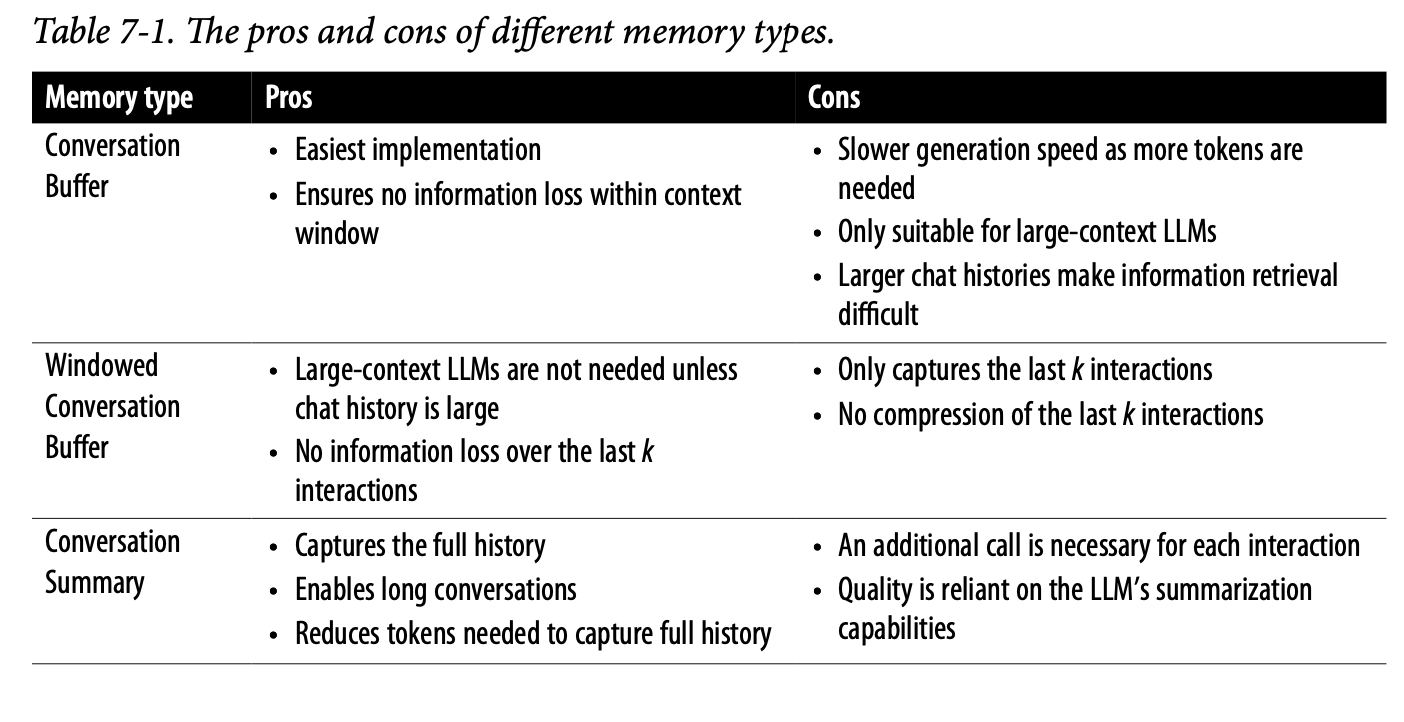

## Agents : Creating a System of LLMs

Agents can make use of everything we have seen thus far, such as model I/O, chains, and memory, and extend it further with two vital components:
- Tools that the agent can use to do things it could not do itself
- The agent type, which plans the actions to take or tools to use

Although the tools Agents use are important, the driving force of many agent-based systems is the use of a framework called Reasoning and Acting (ReAct).

### The Driving Power Behind Agents : Step-by-Step Reasoning

ReAct is a powerful framework that combines two important concepts in behavior: reasoning and acting.

ReAct merges these two concepts and allows reasoning to affect acting and actions to affect reasoning. In practice, the framework consists of iteratively following these
three steps:
- Thought
- Action
- Observation

### ReAct in LangChain

In [ ]:
import os
from langchain_openai import ChatOpenAI


In [ ]:
# Load the OpenAI's LLMs with LangChain
os.environ["OPENAI_API_KEY"] = "MY_KEY"
openai_llm = ChatOpenAI(
    model_name = "gpt-3.5-turbo",
    temperature = 0
)

In [ ]:
# Create the ReAct template
react_template =  """Answer the following questions as best you can. You have
access to the following tools:
{tools}

Use the following format:
Question: the input question you must answer
Thought: you should always think about what to do

Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question
Begin!
Question: {input}
Thought:{agent_scratchpad}"""

prompt = PromptTemplate(
    template = react_template,
    input_variables = ["tools", "tool_names", "input", "agent_scratchpad"]]
)

In [ ]:
from langchain.agents import load_tools, Tool
from langchain.tools import DuckDuckGoSearchResults

In [ ]:
# You can create the tool to pass to an agent
search = DuckDuckGoSearchResults()
search_tool = Tool(
    name = "duckduck",
    description = "A web search engine. Use this to as a search engine for general queries.",
    func = search.run
)

# Prepare tools
tools =  load_tools(["llm-math"], llm = openai_llm)
tools.append(search_tool)

# The tools include the DuckDuckGo search engine and a math tool that allows it to access a basic calculator.

In [ ]:
# Finally we create a ReAct agent
from langchain.agents import AgentExecutor, create_react_agent

# Construct the ReAct agent
agent = create_react_agent(openai_llm, tools, prompt)
agent_executor = AgentExecutor(
    agent = agent,
    tools = tools,
    verbose = True,
    handle_parsing_error = True
)

In [ ]:
# What is the price of a Macbook Pro
agent_executor.invoke(
    {
        "input": """What is the current price of a Macbook Pro in USD ? How much 
    }
)